# **Implementing Transformers for Text Generation**


## Learning Objectives

- Implement Transformers for text generation tasks 

- Build, train, and evaluate Transformer models for text generation using TensorFlow and Keras 

- Apply text generation in real-world scenarios 


----


### Step-by-step instructions 

#### Step 1: Set up the environment 

- Import necessary libraries and load the data set 

- Preprocess the dataset for training 

In the following code: 

- Import TensorFlow and other necessary libraries. 

- Load the Shakespeare text dataset. 

- Preprocess the data set using the TextVectorization layer to convert text into integer sequences. 


In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow.keras.layers import TextVectorization 
from tensorflow.keras.utils import get_file 

In [2]:
path_to_file = get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt') 
text = open(path_to_file, 'rb').read().decode(encoding='utf-8') 

print(text[:1000]) 

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this 

In [3]:
vocab_size = 10000 
seq_length = 100 

vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int') 
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1) 
vectorizer.adapt(text_ds) 

vectorized_text = vectorizer([text])[0] 
print("Vectorized text shape:", vectorized_text.shape) 
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10]) 

Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]


#### Step 2: Create input and target sequences 

Generate input and target sequences for training the Transformer model. 

In the following code: 

- Define a function to generate input and target sequences. 

- Split the text data into sequences of the specified length. 

- Convert the sequences into TensorFlow tensors for training. 

Generative sequence: 


In [4]:
def create_sequences(text, seq_length): 
    input_seqs = [] 
    target_seqs = [] 
    for i in range(len(text) - seq_length): 
        input_seq = text[i:i + seq_length] 
        target_seq = text[i + 1:i + seq_length + 1] 
        input_seqs.append(input_seq) 
        target_seqs.append(target_seq) 
    return np.array(input_seqs), np.array(target_seqs) 

X, Y = create_sequences(vectorized_text.numpy(), seq_length) 

print("Number of sequences generated:", len(X)) 
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated") 

assert X.size > 0, "Input data X is empty" 
assert Y.size > 0, "Target data Y is empty" 
X = tf.convert_to_tensor(X) 
Y = tf.convert_to_tensor(Y) 
print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape)


Number of sequences generated: 202546
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79  506   27    3   56   24 1390
   57   40  161 2328  644    9 4980   34   32   54 2863  885   72   17
   18  163  146  146  165  270   74  218   46  595   89  270   36   41
 6739  172  595    2 1780   46   29 1323 5151   47   58 4151   79   39
   60   58]
Shape of X: (202546, 100)
Shape of Y: (202546, 100)


#### Step 3: Build the Transformer model 

Define the Transformer model architecture for text generation. 

In the following code: 

- Define the TransformerBlock class that includes multi-head attention and feedforward layers with normalization and dropout. 

- Define the TransformerModel class, including embedding, positional encoding, and multiple Transformer blocks. 

- Compile the Transformer model using the Adam optimizer and sparse categorical cross-entropy loss function. 

Transformer model: 


In [5]:
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(Model):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.dense = Dense(vocab_size)

    def positional_encoding(self, seq_length, embed_dim):
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :seq_len, :]
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        output = self.dense(x)
        return output

In [6]:
embed_dim = 256 
num_heads = 4 
ff_dim = 512 
num_layers = 4 

model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()


Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 100, 256)          │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (1, 100, 10000)        │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,393,360 (39.65 MB)

 Trainable params: 10,393,360 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

#### Step 4: Train the Transformer model 

Train the Transformer model on the preprocessed text data. 

In the following code: 

- Train the Transformer model on the input and target sequences 

- Plot the training loss to monitor the model's performance over epochs 

Model training: 


> #### Note: The original dataset is large, we have reduced it to 10,000 samples and limited the training to 2 epochs in order to minimize execution time


In [7]:
X = X[:10000]
Y = Y[:10000]

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 228s 702ms/step - loss: 11.0936
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 240s 766ms/step - loss: 11.0607


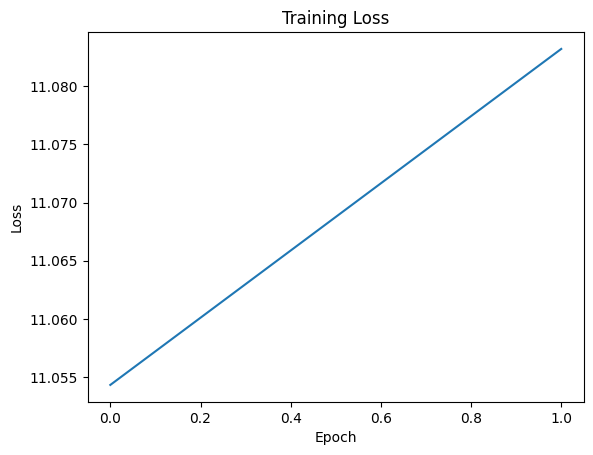

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

history = model.fit(X, Y, epochs=2, batch_size=32, callbacks=[early_stopping])

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


#### Step 5: Generate text with the trained model 

Define a function to generate text using the trained Transformer model. 

In the following code: 

- Define the generate_text function to generate text using the trained Transformer model 

- Convert the start string into numerical format 

- Use the model to predict the next word and append it to the generated text 

- Print the generated text 

#### Text generation: 


In [9]:
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    input_eval = vectorizer([start_string]).numpy()
    
    if input_eval.shape[1] < seq_length:
        
        padding = np.zeros((1, seq_length - input_eval.shape[1]))
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
       
        input_eval = input_eval[:, -seq_length:]

    input_eval = tf.convert_to_tensor(input_eval)
    
    text_generated = []

    for i in range(num_generate):
        predictions = model(input_eval)

        predictions = predictions[0]

        predictions = predictions / temperature
        
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)
        input_eval = input_eval[:, -seq_length:]
        input_eval = tf.convert_to_tensor(input_eval)

        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    return start_string + ' ' + ' '.join(text_generated)

start_string = "To be, or not to be"
generated_text = generate_text(model, start_string, temperature=0.7)
print(generated_text)


To be, or not to be beams wallow league demand [UNK] may quivers thrush knowt had dainty than all issue tot ill percy cobham twofold overheardst gilded county sacrificed richest sneak operation gallant had lusts thoult visible plaster imagination caius cabin appeared pendent forrest trembles am hath harry works contagion teat pouring muck style purchase purge rehearsed unsuspected himself stinking was mistakings unreal thightheres solely refresh had lifted prosperous do untrussing physicians up would servingcreatures caius mutiny acquaint oracle him medler gentlemanlike caius caius peerd hers sign habiliments asleep hitherward sham caius rescue may rudesby lourd geld harms may issue fair caius ireful issue here wanted


### Practice exercises 

> ####  Note: Results may vary since the dataset size was reduced and training was limited to 2 epochs to shorten execution time. However, you are encouraged to experiment with different epoch values for deeper learning

### Exercise 1: Experiment with different sequence lengths 

**Objective:** Implement different sequence lengths to understand their effect on the performance of the Transformer model. 

**Instructions:**

- Change the sequence length to 50 

- Preprocess the data set with the new sequence length 

- Train the model and compare the training loss 


Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]
Number of sequences generated: 202596
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79]
Shape of X: (202596, 50)
Shape of Y: (202596, 50)


Model: "transformer_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (1, 50, 256)           │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ ?                      │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (1, 50, 10000)         │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,393,360 (39.65 MB)

 Trainable params: 10,393,360 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 405ms/step - loss: 11.6851
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 130s 414ms/step - loss: 11.7939


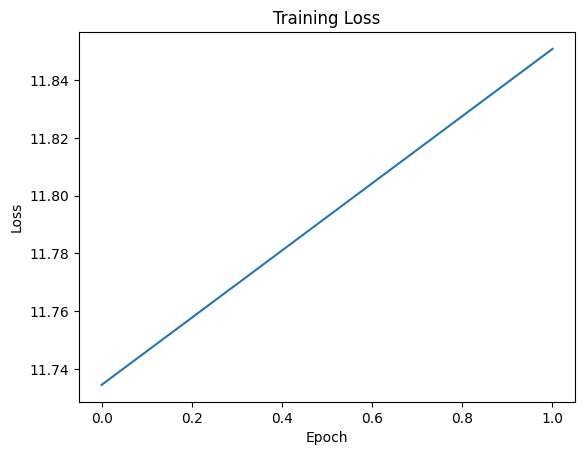

In [10]:
seq_length = 50 

vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int') 
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1) 
vectorizer.adapt(text_ds) 

vectorized_text = vectorizer([text])[0] 
print("Vectorized text shape:", vectorized_text.shape) 
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10]) 

X, Y = create_sequences(vectorized_text.numpy(), seq_length) 


print("Number of sequences generated:", len(X)) 
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated") 

assert X.size > 0, "Input data X is empty" 
assert Y.size > 0, "Target data Y is empty" 
X = tf.convert_to_tensor(X) 
Y = tf.convert_to_tensor(Y) 
print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape)
X = X[:10000]
Y = Y[:10000]
embed_dim = 256 
num_heads = 4 
ff_dim = 512 
num_layers = 4 

model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

history = model.fit(X, Y, epochs=2, batch_size=32, callbacks=[early_stopping])

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### Exercise 2: Add a learning rate scheduler 

**Objective:** Implement a learning rate scheduler to adjust the learning rate during training. 

**Instructions:**

- Define a learning rate scheduler that reduces the learning rate by half every 10 epochs 

- Train the model with the learning rate scheduler and compare the training loss 


Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 126s 801ms/step - loss: 11.7707 - learning_rate: 0.0010
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 116s 741ms/step - loss: 11.7810 - learning_rate: 0.0010


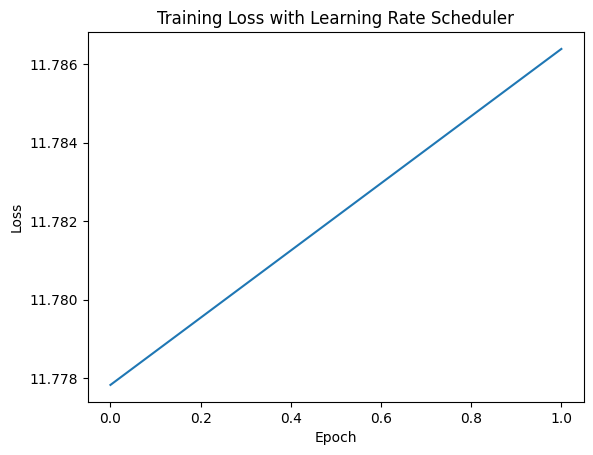

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
 
def scheduler(epoch, lr):  
    if epoch % 10 == 0 and epoch != 0:  
        lr = lr * 0.5  
    return lr  

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)  
 
history = model.fit(X, Y, epochs=2, batch_size=64, callbacks=[callback])  
   
plt.plot(history.history['loss'])  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Training Loss with Learning Rate Scheduler')  
plt.show() 

### Exercise 3: Generate longer text sequences 

**Objective:** To explore the model's text generation capabilities and generate longer sequences. 

**Instructions:**

- Modify the `generate_text` function to generate 200 tokens instead of 100 

- Generate text using the trained model and the modified function 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def generate_text(model, start_string, num_generate=200):
    input_eval = vectorizer([start_string]).numpy()
    input_eval = tf.convert_to_tensor(input_eval[:, -5:])
    text_generated = []

    for i in range(num_generate):
        predictions = model(input_eval)
    
        predictions = predictions[:, -1, :]
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)
        input_eval = input_eval[:, -5:]
        input_eval = tf.convert_to_tensor(input_eval)
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    return start_string + ' ' + ' '.join(text_generated)


start_string = "To be, or not to be"
generated_text = generate_text(model, start_string, num_generate=200)

print(generated_text)

To be, or not to be tides violet elizabeth resists philosophy mechanics people cog behind cool marriagedowry tell officed vineyard thievish from see reserved hardfavourd safe throat power squeakd sugard shin venomd unconsidered punishd undercrest manes laidthere courage statutes vaward seemst fees lecture jerusalem rotten possessd nero smiles ordered vanities scarecrow forswore knave masquers so people softer detested earths unlookd more spotted born prepare leiger people unpolishd prosper scorn resting tasted rushd had shortens prejudicial marchpane steeds marvelld spoil troublest sol tells enfranchisement yea than treachery possessed een conspirators perjury worthy wenchs steward accusation duteous spake will silversweet abused sir revenue suppliant volumnia threeleggd volsces charitable degenerate bay fires masterless breeder nations dost pamper knights marjoram hunger person least prevaild bawd man lustful ridges see mouths stalls tis possesses hideous nose suckd pleader choose cha